In [ ]:
#default_exp corner_detection_training

# UNET segmentation

download smartdoc15_ch1 from `https://github.com/jchazalon/smartdoc15-ch1-pywrapper`
1. git clone
2. pip install .
2. add some import statement if error

In [ ]:
from ocr.core import test
assert test() == 'test'

### prep

In [ ]:
from smartdoc15_ch1 import Dataset, evaluate_segmentation

def prepare_dataset(path):
    return Dataset(data_home=path, download_if_missing=True)
    
DATASET_PATH = "../data/corner_detection"

In [ ]:
d = prepare_dataset(DATASET_PATH)

In [ ]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
# %matplotlib notebook

In [ ]:
def plot(im):
    ax = plt.figure()
    if len(im.squeeze().shape) == 2: plt.imshow(im, cmap='gray')
    else: plt.imshow(im)
    return plt.show()

In [ ]:
# plot(cv2.imread(DATASET_PATH+'/smartdoc15-ch1_home/frames/background01/datasheet001/frame_0034.jpeg'))
# plot(cv2.imread(DATASET_PATH+'/smartdoc15-ch1_home/frames/background02/datasheet001/frame_0034.jpeg'))
# plot(cv2.imread(DATASET_PATH+'/smartdoc15-ch1_home/frames/background03/datasheet001/frame_0034.jpeg'))
# plot(cv2.imread(DATASET_PATH+'/smartdoc15-ch1_home/frames/background04/datasheet001/frame_0034.jpeg'))
# plot(cv2.imread(DATASET_PATH+'/smartdoc15-ch1_home/frames/background05/datasheet001/frame_0034.jpeg'))

In [ ]:
# NOTE: make masks before training
def make_dir(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

def make_masks():
    MASK_PATH = os.path.join(DATASET_PATH, 'masks')
    for example in tqdm(d):
        short_path = example['image_path']
        full_path = example['image_path_absolute']
        mask_path = os.path.join(MASK_PATH, short_path)[:-4] + 'png'
        make_dir(mask_path)
        im = cv2.imread(full_path)
        pts = np.array([example[b] for b in ["tl_x", "tl_y", "bl_x", "bl_y", "br_x", "br_y", "tr_x", "tr_y"]], np.int32)
        pts = pts.reshape((4,1,2))
        empty_img = np.zeros(im.shape[:2], dtype=np.uint8)
        cv2.fillPoly(empty_img, [pts], 1)
        cv2.imwrite(mask_path, empty_img)
# make_masks()

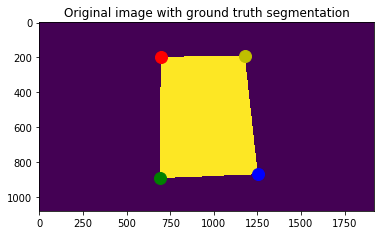

In [ ]:
def show_points_on_mask(mask, o): # o - (8,) shape arr w/ points x,y coords
    plt.imshow(mask)
    for i, c in zip(range(0,8,2), ['r', 'g', 'b', 'y']):
        plt.plot(o[i], o[i+1], c+'o-', linewidth=2, markersize=12)
        plt.title("Original image with ground truth segmentation")

# for some reason cv2 reads w/ 3 channels
mask = cv2.imread(DATASET_PATH + '/masks/background01/datasheet001/frame_0001.png')[:,:,0]
show_points_on_mask(mask, (698, 200, 692, 891, 1253, 869, 1178, 191))

In [ ]:
filenames = [os.path.join('', example['image_path']) for example in d]
filenames_df = pd.DataFrame(filenames, columns=['image_path'])

In [ ]:
filenames_df['valid'] = [fn.split('/')[0] == 'background01' for fn in filenames]
filenames_df.head()

,image_path,valid
0,background01/datasheet001/frame_0001.jpeg,True
1,background01/datasheet001/frame_0002.jpeg,True
2,background01/datasheet001/frame_0003.jpeg,True
3,background01/datasheet001/frame_0004.jpeg,True
4,background01/datasheet001/frame_0005.jpeg,True


In [ ]:
# small_df = filenames_df[-8000:]

In [ ]:
n = 20 # take only every n'th element
sparse_df = filenames_df.iloc[::n]
sparse_df.head(), len(sparse_df)

(                                   image_path  valid
 0   background01/datasheet001/frame_0001.jpeg   True
 20  background01/datasheet001/frame_0021.jpeg   True
 40  background01/datasheet001/frame_0041.jpeg   True
 60  background01/datasheet001/frame_0061.jpeg   True
 80  background01/datasheet001/frame_0081.jpeg   True, 1245)

In [ ]:
print(d.segmentation_targets.shape, len(filenames))
fn2points = {fn:p.squeeze()[[1,0,3,2,5,4,7,6]].reshape([4,2]) for fn, p in zip(filenames, d.segmentation_targets)}

(24889, 8) 24889


In [ ]:
fn2points['background01/datasheet001/frame_0005.jpeg']

array([[ 205.898,  696.853],
       [ 883.791,  690.721],
       [ 862.077, 1240.38 ],
       [ 196.579, 1167.82 ]])

In [ ]:
def sort_points(points): # [4,2] arr of points
    ''' gets [4,2] arr of points, returns sorted [(tl,tr,br,bl),2] '''
    sorted_by_y = sorted(points, key=lambda x: x[1]) # x - [2] shape np arr
    potential_01 = sorted_by_y[:2]
    potential_23 = sorted_by_y[2:]
    i0, i1 = sorted(potential_01, key=lambda x: x[0])
    i3, i2 = sorted(potential_23, key=lambda x: x[0])
    return torch.stack([i0, i1, i2, i3], axis=0)

In [ ]:
dataset_path = '/'.join([DATASET_PATH, 'smartdoc15-ch1_home', 'frames'])

### Transforms

In [ ]:
#export
import string
from PIL import Image, ImageDraw, ImageFont

def _textify(x, p=0.9):
    val = np.random.random_sample()

    if np.random.random_sample() < p:
        pil_img = PIL.Image.fromarray(image2np(x*255).astype(np.uint8))
        
        w, h = pil_img.size
        text_loc = (random.randint(0,w//2),random.randint(0,h//2))
        text_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        text_length = random.randint(1,10)
        create_string = lambda: random.sample(string.printable, 1)[0]+random.sample(string.ascii_letters, 1)[0]
        text = ''.join([create_string() for i in range(text_length)])
        text_size = random.randint(3,30)
        font = ImageFont.FreeTypeFont("../fonts/arial.ttf", size=text_size)
        ImageDraw.Draw(pil_img).text(text_loc, text, fill=text_color, font=font)

        x = pil2tensor(pil_img,np.float32)
        x.div_(255)
    return x

def textify(p=1.0):
    return RandTransform(tfm=TfmPixel(_textify), kwargs={}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [ ]:
#export
def _gaussian_blur(x, size:uniform_int):
    blurred = cv2.blur(image2np(x), (size,size)) # np.arr
#     blurred = cv2.GaussianBlur(image2np(x), (size,size), 0)
    return tensor(blurred).permute(2,0,1)

# gaussian_blur = TfmPixel(_gaussian_blur)
def gaussian_blur(size, p=1.0):
    return RandTransform(tfm=TfmPixel(_gaussian_blur), kwargs={'size':size}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [ ]:
train_transforms = [
    crop_pad(),
    rotate(degrees=(-30, 30), p=0.9),
    symmetric_warp(magnitude=(-0.2, 0.2), p=0.9),
    dihedral_affine(p=1), # (flips image), will cause problems, because top left corner will be for example bottom right
    rand_zoom(scale=(1.,1.1), p=0.9),
    brightness(change=(0.4, 0.6), p=0.8),
    contrast(scale=(0.8,1.2), p=0.8),
    textify(),
#     gaussian_blur(size=(1, 3), p=0.8)
]

valid_transforms = [
#     crop_pad()
]

### Databunch

In [ ]:
#export
def get_mask_fn(filepath):
    fp_split = filepath.split('/')
    return os.path.join(*(fp_split[:3] + ['masks'] + fp_split[-3:]))[:-4] + 'png'

In [ ]:
#export
resize_tuple = lambda shape, k: (int(shape[0]/k), int(shape[1]/k))
input_shape = resize_tuple([1080,1920], 10)

In [ ]:
data = (SegmentationItemList.from_df(sparse_df, path=dataset_path, cols='image_path')
       .split_from_df(col='valid')
       .label_from_func(get_mask_fn, classes=[0,1])
       .transform((train_transforms, valid_transforms), tfm_y=True, size=input_shape)
       .databunch(bs=4)
       .normalize(imagenet_stats)
       )
data

ImageDataBunch;

Train: LabelList (936 items)
x: SegmentationItemList
Image (3, 108, 192),Image (3, 108, 192),Image (3, 108, 192),Image (3, 108, 192),Image (3, 108, 192)
y: SegmentationLabelList
ImageSegment (1, 108, 192),ImageSegment (1, 108, 192),ImageSegment (1, 108, 192),ImageSegment (1, 108, 192),ImageSegment (1, 108, 192)
Path: ../data/corner_detection/smartdoc15-ch1_home/frames;

Valid: LabelList (309 items)
x: SegmentationItemList
Image (3, 108, 192),Image (3, 108, 192),Image (3, 108, 192),Image (3, 108, 192),Image (3, 108, 192)
y: SegmentationLabelList
ImageSegment (1, 108, 192),ImageSegment (1, 108, 192),ImageSegment (1, 108, 192),ImageSegment (1, 108, 192),ImageSegment (1, 108, 192)
Path: ../data/corner_detection/smartdoc15-ch1_home/frames;

Test: None

In [ ]:
data.train_ds[0][0].data[0,:5,:5], data.train_ds[0][1].data, data.train_ds[0][0].data.shape

(tensor([[0.6314, 0.6353, 0.6431, 0.6314, 0.6275],
         [0.6314, 0.6314, 0.6392, 0.6314, 0.6275],
         [0.6275, 0.6314, 0.6353, 0.6353, 0.6353],
         [0.6196, 0.6235, 0.6275, 0.6314, 0.6353],
         [0.6196, 0.6235, 0.6235, 0.6235, 0.6275]]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]),
 torch.Size([3, 108, 192]))

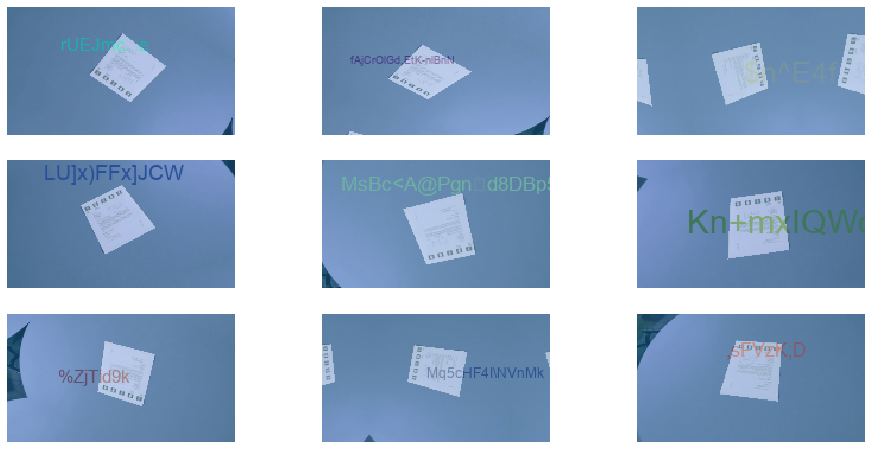

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[100]
#     print(np.unique(to_np(y), return_counts=True))
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(16,8))

### Train

In [ ]:
#export
def acc_camvid(input, target, void_code=0):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
learner = unet_learner(data, models.resnet18, metrics=[acc_camvid], wd=1e-2)
learner.callbacks.append(ShowGraph(learner))
print(input_shape)
learner.summary()

(108, 192)


DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 54, 96]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 54, 96]         128        True      
______________________________________________________________________
ReLU                 [64, 54, 96]         0          False     
______________________________________________________________________
MaxPool2d            [64, 27, 48]         0          False     
______________________________________________________________________
Conv2d               [64, 27, 48]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 27, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 27, 48]         0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 2.51E-04


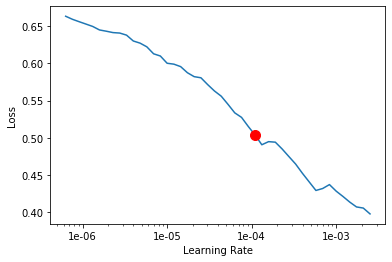

In [ ]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.085495,0.044572,0.869677,00:17
1,0.042738,0.011848,0.965071,00:17
2,0.030714,0.006692,0.986035,00:17
3,0.023642,0.005372,0.988379,00:17
4,0.021726,0.006091,0.984688,00:17


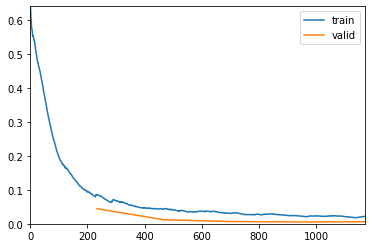

In [ ]:
learner.fit_one_cycle(5, slice(1e-4))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.024251,0.015425,0.997062,00:18
1,0.023454,0.006202,0.981933,00:18
2,0.020436,0.005030,0.987868,00:18
3,0.016528,0.004836,0.987598,00:18


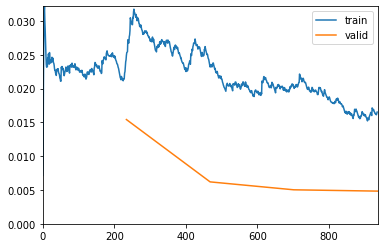

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(4, slice(5e-6,1e-4))

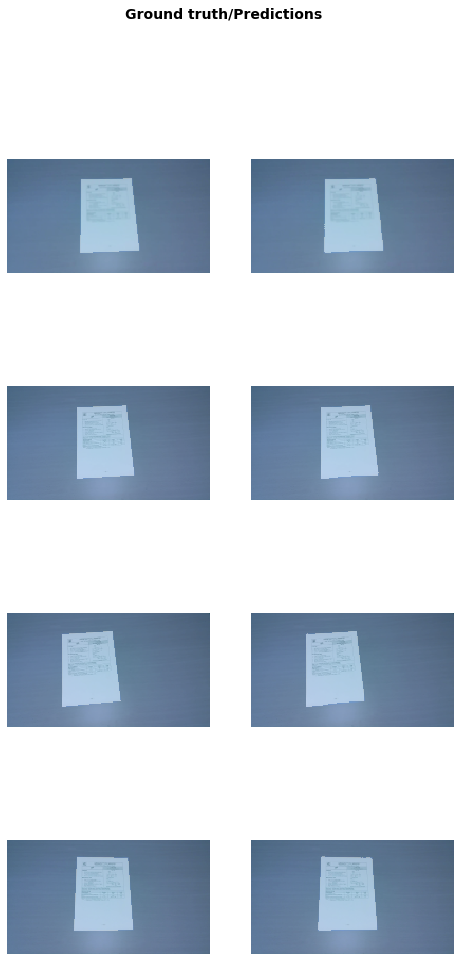

In [ ]:
learner.show_results()

In [ ]:
from ocr.core import save_inference

# save_inference(learner, 'unet_paper_mask')

In [ ]:
learner = load_learner('../models', 'unet_paper_mask')

In [ ]:
from fastai.vision import Image

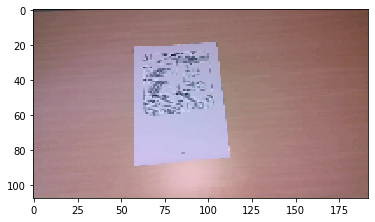

torch.Size([3, 108, 192])


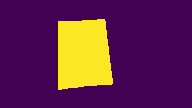

In [ ]:
im = cv2.imread(DATASET_PATH+'/smartdoc15-ch1_home/frames/background01/datasheet001/frame_0034.jpeg')
im = im[ :, :, [2,1,0] ] # BGR -> RGB
im = cv2.resize(im, (192,108))
plot(im)
im = Image(tensor(im).permute(2,0,1).float() / 255.)

print(im.shape)

learner.model.eval()
pred = learner.predict(im)
pred[0]

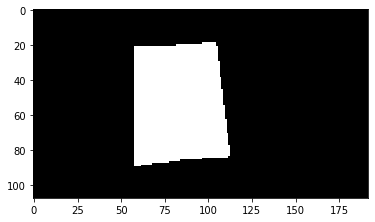

In [ ]:
plot(pred[0].data[0])

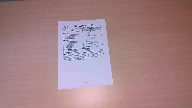

In [ ]:
im

# Evaluate

In [ ]:
#export
def resize(im, new_height):
    height, width = im.shape[:2]
    h_ratio = height / new_height
    im = cv2.resize(im, (int(width/h_ratio), int(height/h_ratio)))
    return im, h_ratio

def detect_object(img, image_height=100, canny_threshold=0):
    # img - (200,300) shape
    
    # Reduce the image
    if image_height is not None:
        img, h_ratio = resize(img, image_height)
    
    # Convert to grayscale if we have a color image
    if len(img.shape) == 3:
        # we keep only the luminance
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[..., 1]
        
    height, width = img.shape
    cx = width // 2
    cy = height // 2

    # Default value for results: return fhe whole frame if we cannot find any object
    tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y = ( 0., 0., 0., 0., 0., 0., 0., 0.)

    # Remove small components
    closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    blurred = cv2.blur(closed, (3,3))

    # Binarize
    binary = cv2.Canny(blurred.astype(np.uint8), 0, canny_threshold, 3)

    # Contour extraction
    # Since opencv 3.2 source image is not modified by this function (and the API changed...)
#     _image, contours, _hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, _hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Select the best contour
    if len(contours) > 0:
        good_contours = []  # list of contours
        distances = None  # list of floats

        # First check for contours around the center point
        for cnt in contours:
            hull = cv2.convexHull(cnt)
            dist = cv2.pointPolygonTest(hull,(cx,cy), False)  # fast inclusion test
            if dist > 0:  # The center point is included in the convex hull of the contour
                good_contours.append(hull)

        # If no match, pick the contours with the greatest curve length
        if len(good_contours) == 0:
            dists1 = [cv2.arcLength(cnt, False) for cnt in contours]
            idx1 = np.argsort(dists1)[::-1]  # reverse order
            # Keep at most 5 contours
            good_contours = [contours[ii] for ii in idx1[:5]]
            
        # if we finally have good contours
        if len(good_contours) >= 0:
            # Compute exact distances to center
            distances =  [cv2.pointPolygonTest(cnt, (cx,cy), True) for cnt in good_contours]
            idx = np.argsort(distances)  # get the indices to sort the contours by distance
            # keep the 5 best contour
            for i in idx:
                best_contour = good_contours[i]
                # Polygonal approximation
                approx = cv2.approxPolyDP(best_contour,0.1*cv2.arcLength(best_contour,True),True)

                # check we have quadrilateral and assign corners
                if len(approx) == 4:              
                    xs = [approx[0][0][0],approx[1][0][0],approx[2][0][0],approx[3][0][0]]
                    ys = [approx[0][0][1],approx[1][0][1],approx[2][0][1],approx[3][0][1]]
                    idx = np.argsort(ys)
                    top = [[xs[idx[0]],ys[idx[0]]],[xs[idx[1]],ys[idx[1]]]]
                    bottom = [[xs[idx[2]],ys[idx[2]]],[xs[idx[3]],ys[idx[3]]]]
                    if top[0][0] > top[1][0]:
                        tl_x, tl_y = top[1]
                        tr_x, tr_y = top[0]
                    else:
                        tl_x, tl_y = top[0]
                        tr_x, tr_y = top[1]
                    if bottom[0][0] > bottom[1][0]:
                        bl_x, bl_y = bottom[1]
                        br_x, br_y = bottom[0]
                    else:
                        bl_x, bl_y = bottom[0]
                        br_x, br_y = bottom[1]
                    break
    
    out = (tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y)
    
    if image_height is not None:
        out = tuple( np.array(out) * h_ratio )

    return out

In [ ]:
def evaluate(y_pred, y_true, print_summary=True):
    ''' both w/ shape [n,8] -> return [n] shape arr w/ IoU '''
    return evaluate_segmentation(y_pred, y_true, d.model_shapes[:len(y_true)], print_summary=True)

In [ ]:
x = d.segmentation_targets / 4
evaluate(x, x)

----------------------------------------------
   evaluate_segmentation: Evaluation report
----------------------------------------------
metric: IoU (aka Jaccard index)
----------------------------------------------
observations: 24889
mean:             1.00 (CI@95%: 1.000, 1.000)
min-max:          1.000 - 1.000
variance:         0.000 (std: 0.000)
----------------------------------------------


array([1., 1., 1., 1., ..., 1., 1., 1., 1.])

In [ ]:
def get_pred_and_true(image, mask):
    ''' ([3,h,w], [1,h,w]) from data.valid_ds -> ([8], [8]) uint8 '''
    pred,_,_ = learner.predict(image)
    pred, mask = pred.data[0].numpy(), mask.data[0].numpy() # remove [1,...] at beginning
    pred_o = detect_object(pred.astype(np.uint8), image_height=None)
    mask_o = detect_object(mask.astype(np.uint8), image_height=None)
    return pred_o, mask_o

In [ ]:
# NOTE: this shows how good is `detect_object` on ground truth mask
df = sparse_df
y_true, y_pred = [], []
for i, (image, mask) in tqdm(zip(df[df['valid'] == True].index, data.valid_ds), total=len(data.valid_ds)):
    # this true_points is detected from detect_object on ground truth mask
    _, pred_points = get_pred_and_true(image, mask)
    true_points = np.array([d[i][b] for b in ["tl_x", "tl_y", "bl_x", "bl_y", "br_x", "br_y", "tr_x", "tr_y"]], np.int32)
    y_pred.append(pred_points), y_true.append(true_points) # rescale coords

evaluate(np.array(y_pred), np.array(y_true)/(1080/input_shape[0]))


----------------------------------------------
   evaluate_segmentation: Evaluation report
----------------------------------------------
metric: IoU (aka Jaccard index)
----------------------------------------------
observations:   309
mean:             0.95 (CI@95%: 0.945, 0.948)
min-max:          0.885 - 0.973
variance:         0.000 (std: 0.014)
----------------------------------------------


array([0.965425, 0.962971, 0.961624, 0.948248, ..., 0.949745, 0.954446, 0.950918, 0.949277])

In [ ]:
y_true, y_pred = [], []

for i, (image, mask) in tqdm(zip(df[df['valid'] == True].index, data.valid_ds), total=len(data.valid_ds)):
    # this true_points is detected from detect_object on ground truth mask it scores (~94.2)
    pred_points, true_points = get_pred_and_true(image, mask)
#     true_points = np.array([d[i][b] for b in ["tl_x", "tl_y", "bl_x", "bl_y", "br_x", "br_y", "tr_x", "tr_y"]], np.int32) / (1080/input_shape[0]) # rescale coords
    y_pred.append(pred_points), y_true.append(true_points)

evaluate(np.array(y_pred), np.array(y_true)) # ~85 on predicted mask, ~84 on true labels


----------------------------------------------
   evaluate_segmentation: Evaluation report
----------------------------------------------
metric: IoU (aka Jaccard index)
----------------------------------------------
observations:   309
mean:             0.97 (CI@95%: 0.971, 0.975)
min-max:          0.908 - 1.000
variance:         0.000 (std: 0.018)
----------------------------------------------


array([1.      , 1.      , 0.991454, 0.949576, ..., 1.      , 0.932497, 0.974773, 0.939997])

In [ ]:
def show_element(data_element):
    
    image, mask = data_element
    pred_points, true_points = get_pred_and_true(*data_element)
    mean, std = list(map(lambda x: torch.tensor(x), imagenet_stats))
    im = denormalize(image.data, mean, std).numpy()
    im = np.transpose(im, [1,2,0])
    
    pred,_,_ = learner.predict(image)
    pred_mask = pred.data[0].numpy()
    
    show_example(im, pred_mask, pred_points, true_points)

In [ ]:
def show_example(d0_img_c, pred_img, predicted_seg, true_seg):
    d0_predseg_x = tuple(predicted_seg[0::2]) + (predicted_seg[0],)
    d0_predseg_y = tuple(predicted_seg[1::2]) + (predicted_seg[1],)
    
    true_seg_x = tuple(true_seg[0::2]) + (true_seg[0],)
    true_seg_y = tuple(true_seg[1::2]) + (true_seg[1],)

    plt.figure(figsize=(9,5))
    plt.subplot(1,2,1)
    plt.imshow(d0_img_c)
    for i, c in zip(range(4), ['r', 'g', 'b', 'y']):
        plt.plot(true_seg_x[i], true_seg_y[i], c+'o-', linewidth=2, markersize=12)
        plt.title("Original image with ground truth segmentation")
    plt.subplot(1,2,2)
    plt.imshow(pred_img)
    for i, c in zip(range(4), ['r', 'g', 'b', 'y']):
        plt.plot(d0_predseg_x[i], d0_predseg_y[i], c+'o-', linewidth=2, markersize=12)
        plt.title("Original image with predicted segmentation")
    plt.title("Original image with predicted segmentation")
    plt.show()

In [ ]:
%matplotlib inline

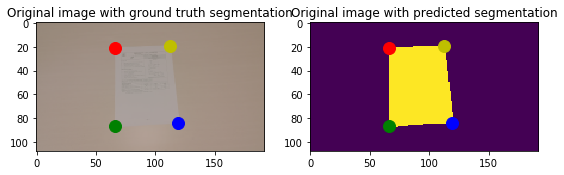

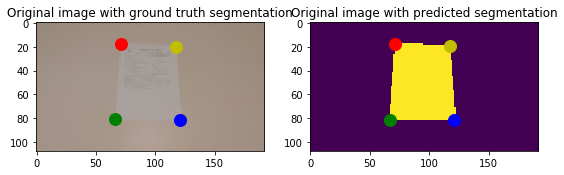

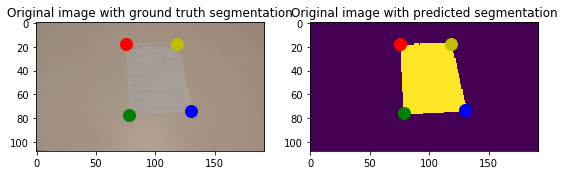

In [ ]:
# show_element(data.train_ds[10])
# show_element(data.train_ds[50])
# show_element(data.train_ds[100])
show_element(data.valid_ds[1])
show_element(data.valid_ds[10])
show_element(data.valid_ds[20])

# W/out Unet (just CV)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = sparse_df
y_pred = []
y_true = []
for i in tqdm(df[df['valid'] == True].index):
    im = d[i].read_image(color=True)
    o = detect_object(im, image_height=108, canny_threshold=95)
    pts = np.array([d[i][b] for b in ["tl_x", "tl_y", "bl_x", "bl_y", "br_x", "br_y", "tr_x", "tr_y"]], np.int32)
    y_pred.append(np.array(o).astype(np.int32))
    y_true.append(pts)

evaluate(np.array(y_pred), np.array(y_true))


----------------------------------------------
   evaluate_segmentation: Evaluation report
----------------------------------------------
metric: IoU (aka Jaccard index)
----------------------------------------------
observations:   309
mean:             0.86 (CI@95%: 0.834, 0.881)
min-max:          0.000 - 0.978
variance:         0.045 (std: 0.212)
----------------------------------------------


array([0.      , 0.972478, 0.795113, 0.96726 , ..., 0.924299, 0.793931, 0.955643, 0.874233])